In [1]:
library(tidyverse)
library(caret)
library(MASS)
library(pROC)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




In [2]:
DatasetPath <- "./train.csv"
mysubset <- read.csv(DatasetPath)

In [3]:
# shrink dataset
shrink <- function (dataset, shrinkRatio) {
    count <- nrow(dataset); shrinkIndex <- sample(count, count * shrinkRatio)
    dataset <- dataset[shrinkIndex,]
    dataset
}

In [4]:
# split into training and holdout dataset
splitDataset <- function (dataset, holdoutRatio) {
    count <- nrow(dataset); trainingIndex <- sample(count, count * (1 - holdoutRatio))
    list(training = dataset[trainingIndex,], holdout = dataset[-trainingIndex,])
}

In [5]:
augmentRightTurn <- function(dataset) {
    isRightTurn <- function(entry, exit) {
        rightexit <- list(
            N = c("NW", "W", "SW"),
            NW = c("W", "SW", "S"),
            W = c("SW", "S", "SE"),
            SW = c("S", "SE", "E"),
            S = c("SE", "E", "NE"),
            SE = c("E", "NE", "N"),
            E = c("NE", "N", "NW"),
            NE = c("N", "NW", "W")
        )
        exit %in% rightexit[[entry]]
    }
    vIsRightTurn <- Vectorize(isRightTurn)
    t <- dataset %>% 
        mutate(RightTurn = vIsRightTurn(EntryHeading, ExitHeading)) %>%
        group_by(IntersectionId, EntryHeading) %>%
        summarize(RightTurnAllowed = max(RightTurn)) %>%
        inner_join(dataset)
    t %>% mutate(RightTurn = vIsRightTurn(EntryHeading, ExitHeading))
}

In [6]:
augmentLeftTurn <- function(dataset) {
    isLeftTurn <- function(entry, exit) {
        leftexit <- list(
            N = c("NE", "E", "SE"),
            NW = c("N", "NE", "E"),
            W = c("NW", "N", "NE"),
            SW = c("W", "NW", "N"),
            S = c("SW", "W", "NW"),
            SE = c("S", "SW", "W"),
            E = c("SE", "S", "SW"),
            NE = c("E", "SE", "S")
        )
        exit %in% leftexit[[entry]]
    }
    vIsLeftTurn <- Vectorize(isLeftTurn)
    t <- dataset %>% 
        mutate(LeftTurn = vIsLeftTurn(EntryHeading, ExitHeading)) %>%
        group_by(IntersectionId, EntryHeading) %>%
        summarize(LeftTurnAllowed = max(LeftTurn)) %>%
        inner_join(dataset)
    t %>% mutate(LeftTurn = vIsLeftTurn(EntryHeading, ExitHeading))
}

In [7]:
intervalScore=function(predObj,actual,alpha) { 
    n=nrow(predObj)
    ilow=(actual<predObj[,2]) # underestimation
    ihigh=(actual>predObj[,3]) # overestimation
    sumlength=sum(predObj[,3]-predObj[,2]) # sum of lengths of prediction intervals
    sumlow=sum(predObj[ilow,2]-actual[ilow])*2/alpha
    sumhigh=sum(actual[ihigh]-predObj[ihigh,3])*2/alpha
    avglength=sumlength/n
    IS=(sumlength+sumlow+sumhigh)/n # average length + average under/over penalties
    cover=mean(actual>= predObj[,2] & actual<=predObj[,3])
    summ=c(1-alpha,avglength,IS,cover)
    summ
}

In [43]:
RMSE <- function(predicted, expected, log=0) {
  if (log == 0){
      sqrt(mean((predicted - expected)^2))
  } else {
      temp <- which(predicted == 0)
      epred <- exp(predicted)
      epred[temp] <- 0
      sqrt(mean((epred- expected)^2)) 
  }
}

In [8]:
oAugment <- augmentRightTurn(mysubset)
oAugment <- augmentLeftTurn(oAugment)
oAugment <- oAugment %>% mutate(straightThrough = EntryHeading == ExitHeading)
oAugment <- oAugment %>% mutate(waitRequired = TotalTimeStopped_p50 > 0)
oAugment <- oAugment %>% mutate(
    JanAndMay = Month == 1 | Month == 5,
    rushHour = (Hour >= 6 & Hour <= 9) | (Hour >= 15 & Hour <= 18))

`summarise()` regrouping output by 'IntersectionId' (override with `.groups` argument)

Joining, by = c("IntersectionId", "EntryHeading")

`summarise()` regrouping output by 'IntersectionId' (override with `.groups` argument)

Joining, by = c("IntersectionId", "EntryHeading")



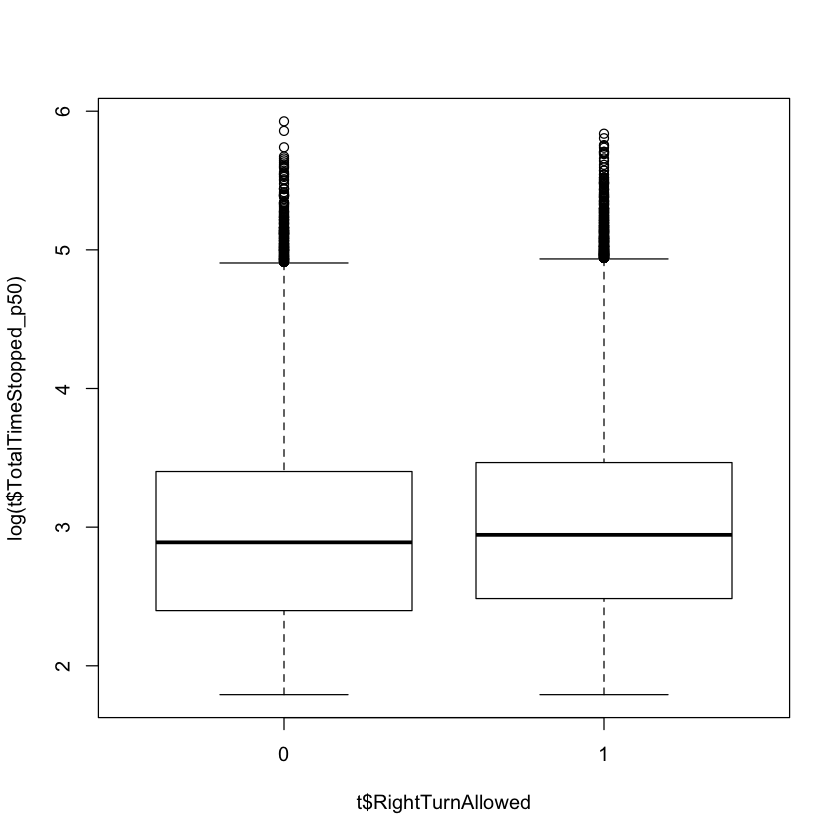

In [9]:
t <- oAugment %>% filter(TotalTimeStopped_p50 > 0)
boxplot(log(t$TotalTimeStopped_p50) ~ t$RightTurnAllowed)

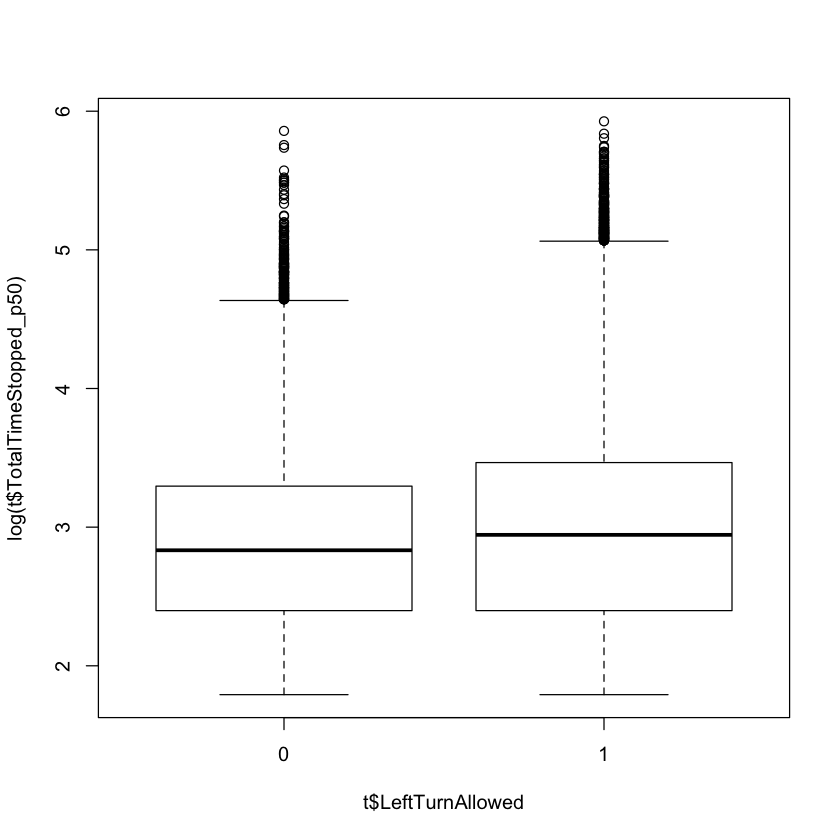

In [10]:
t <- oAugment %>% filter(TotalTimeStopped_p50 > 0)
boxplot(log(t$TotalTimeStopped_p50) ~ t$LeftTurnAllowed)

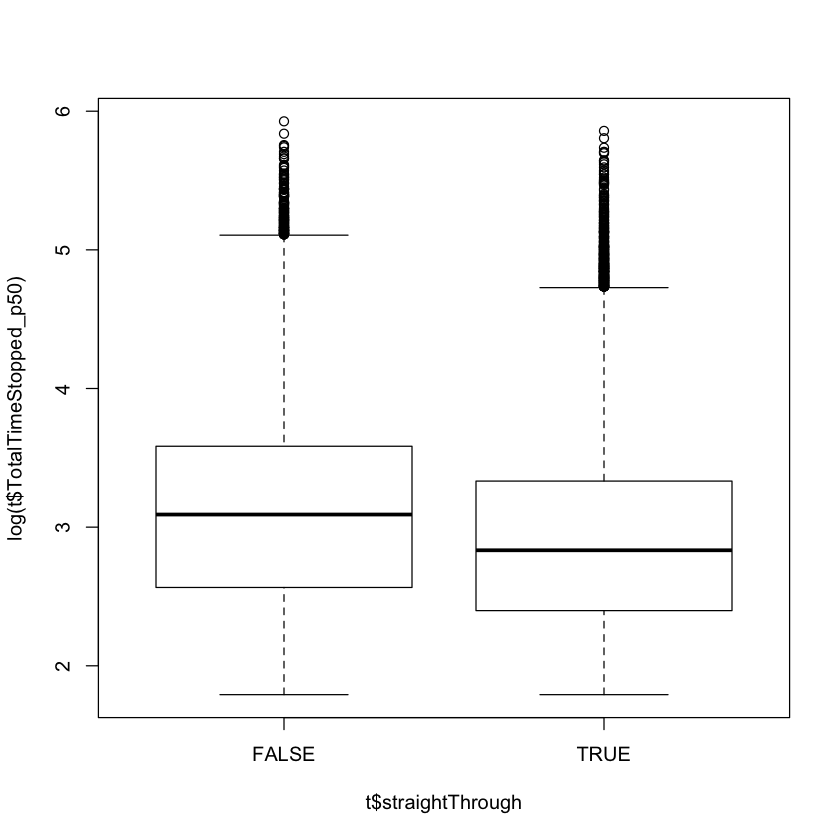

In [11]:
t <- oAugment %>% filter(TotalTimeStopped_p50 > 0)
boxplot(log(t$TotalTimeStopped_p50) ~ t$straightThrough)

In [12]:
workingDataset <- splitDataset(oAugment, 0.2)

In [16]:
eq <- waitRequired ~ Hour + Month + Hour * rushHour + rushHour + LeftTurn * rushHour + straightThrough + straightThrough * rushHour + Weekend + Weekend * rushHour + JanAndMay + City + LeftTurnAllowed + RightTurnAllowed + LeftTurn + RightTurn

In [17]:
str(workingDataset$training)

tibble [685,109 × 36] (S3: grouped_df/tbl_df/tbl/data.frame)
 $ IntersectionId         : int [1:685109] 429 423 905 368 122 914 1802 661 1625 1750 ...
 $ EntryHeading           : Factor w/ 8 levels "E","N","NE","NW",..: 8 2 5 4 5 2 1 1 5 1 ...
 $ LeftTurnAllowed        : int [1:685109] 0 1 0 1 1 1 1 1 1 1 ...
 $ RightTurnAllowed       : int [1:685109] 1 0 1 0 1 1 0 0 0 0 ...
 $ RowId                  : int [1:685109] 2481501 2053639 2569193 2136172 2416134 2572487 2339197 2522330 2708388 2729720 ...
 $ Latitude               : num [1:685109] 40 33.7 40 42.3 40 ...
 $ Longitude              : num [1:685109] -75.1 -84.4 -75.2 -71.1 -75.2 ...
 $ EntryStreetName        : Factor w/ 1724 levels "","10th Street Northeast",..: 1122 1410 898 750 871 1211 1541 1374 1175 1092 ...
 $ ExitStreetName         : Factor w/ 1704 levels "","10th Street Northeast",..: 1099 1376 882 736 856 1190 1511 1343 696 1069 ...
 $ ExitHeading            : Factor w/ 8 levels "E","N","NE","NW",..: 8 3 5 4 5 2 1 1 8 1 

In [18]:
m <- qda(eq, data = workingDataset$training)

In [20]:
p <- predict(m, workingDataset$holdout)

In [23]:
a <- table(predictions = p$posterior[,1] < 0.5, truevalue = workingDataset$holdout$waitRequired)
a
a[1, 2] + a[2, 1]

           truevalue
predictions FALSE  TRUE
      FALSE 78587 24812
      TRUE  38489 29390

[1] 63301

Setting levels: control = FALSE, case = TRUE

Setting direction: controls > cases



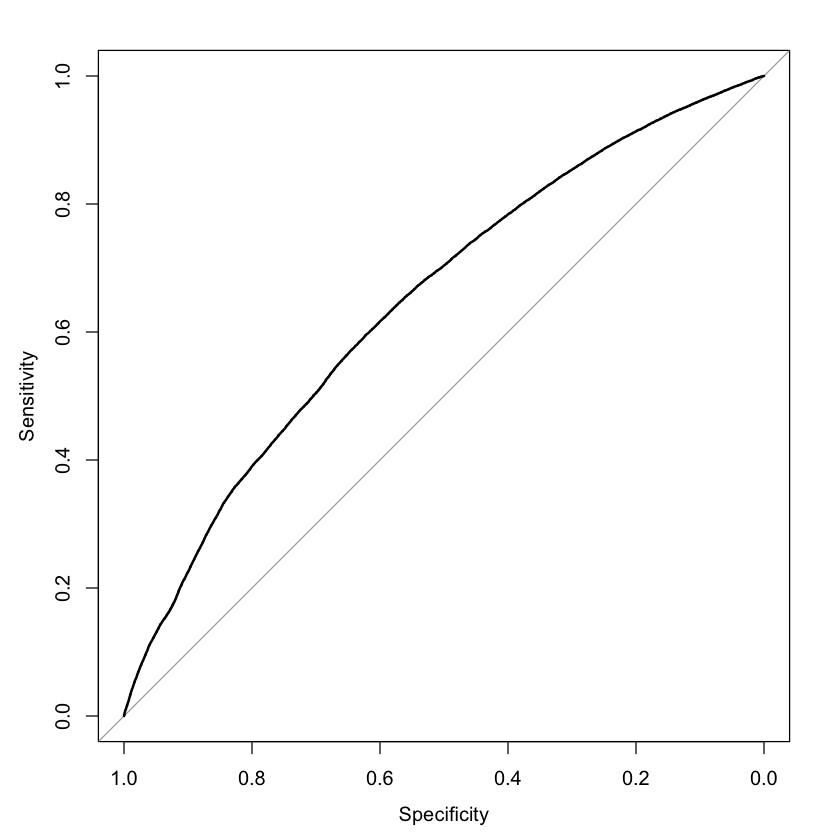

In [25]:
r <- roc(workingDataset$holdout$waitRequired, p$posterior[,1])
plot(r)

In [28]:
# prepare new training set
trainingGreaterThanZero <- workingDataset$training %>% filter(TimeFromFirstStop_p50 > 0)

In [29]:
# prepare new holdout set
workingDataset$holdout$classification <- p$posterior[,1] < 0.5
holdoutGreaterThanZero <- workingDataset$holdout %>% filter(classification == 1)

In [30]:
eqref <- TimeFromFirstStop_p50 ~ Hour + Month + Hour * rushHour + rushHour + LeftTurn * rushHour + straightThrough + straightThrough * rushHour + Weekend + Weekend * rushHour + JanAndMay + City + LeftTurnAllowed + RightTurnAllowed + LeftTurn + RightTurn

In [32]:
lmobj <- lm(eqref, trainingGreaterThanZero)

In [33]:
summary(lmobj)


Call:
lm(formula = eqref, data = trainingGreaterThanZero)

Residuals:
    Min      1Q  Median      3Q     Max 
-47.885 -16.150  -6.537   8.159 315.814 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      41.72802    0.41146 101.415  < 2e-16 ***
Hour                              0.04719    0.01272   3.710 0.000207 ***
Month                            -0.05260    0.02934  -1.793 0.072955 .  
rushHourTRUE                     -0.50448    0.36540  -1.381 0.167390    
LeftTurnTRUE                     -1.93806    0.18157 -10.674  < 2e-16 ***
straightThroughTRUE              -4.31138    0.16239 -26.549  < 2e-16 ***
Weekend                          -1.89326    0.18044 -10.492  < 2e-16 ***
JanAndMayTRUE                     0.02217    3.14505   0.007 0.994375    
CityBoston                       -2.92287    0.18546 -15.760  < 2e-16 ***
CityChicago                      -6.26518    0.21547 -29.077  < 2e-16 ***
CityPhiladelphia  

In [48]:
lmprediction <- predict(lmobj, holdoutGreaterThanZero, interval="prediction")

In [35]:
intervalScore=function(predObj,actual,alpha)
{ n=nrow(predObj)
    ilow=(actual<predObj[,2]) # underestimation
    ihigh=(actual>predObj[,3]) # overestimation
    sumlength=sum(predObj[,3]-predObj[,2]) # sum of lengths of prediction intervals
    sumlow=sum(predObj[ilow,2]-actual[ilow])*2/alpha
    sumhigh=sum(actual[ihigh]-predObj[ihigh,3])*2/alpha
    avglength=sumlength/n
    IS=(sumlength+sumlow+sumhigh)/n # average length + average under/over penalties
    cover=mean(actual>= predObj[,2] & actual<=predObj[,3])
    summ=c(1-alpha,avglength,IS,cover)
    summ
}

In [49]:
RMSE(lmprediction, holdoutGreaterThanZero$TotalTimeStopped_p50)

[1] 56.85749

In [50]:
intervalScore(lmprediction, holdoutGreaterThanZero$TotalTimeStopped_p50, 0.5)

[1]   0.5000000 105.0269352 105.8196094   0.9797434